In [1]:
import os; import sys ; import matplotlib as mpl ; import matplotlib.pyplot as plt ; import numpy as np ; from flopy.plot.styles import styles
import pathlib; from pathlib import Path; import pandas as pd; import flopy ; from modflow_devtools.misc import get_env, timed
from pprint import pformat; import csv ; from flopy.utils.util_array import read1d; from PIL import Image
write = get_env("WRITE", True) ; run = get_env("RUN", True) ;  plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True) ; plot_save = get_env("PLOT_SAVE", True)

In [2]:
example_name = "ex-gwt-mt3dms-p08"
exe_name_mf = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf2005'
exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\bin\\mt3d-usgs_1.1.0_64'         # mt3dusgs
datadir = 'E:\\15_REPOS\\00_BETAMI\\bin\\mt3dms'
# current_directory = os.getcwd();  print(current_directory)

In [3]:
path = pathlib.Path('E:\\15_REPOS\\00_BETAMI\\98_Plus\\02_MT3D')
path.mkdir(parents=True, exist_ok=True); os.chdir(path); current_directory = os.getcwd()
directory_name = 'C_p08_V01'    ; workspace = os.path.join('.', directory_name)
if os.path.isdir(workspace) is False:
    os.mkdir(workspace) 
output_folder = Path('C_p08_V01') ; output_folder.mkdir(exist_ok=True)

In [4]:
# Parameters
nlay=27 ;  nrow=1 ;  ncol=50 ;  delr=5.0 ;  delc=1.0 ;  delz=0.25 ;  top=6.75 ;  prsity=0.35 ;  dm=5.0e-4 ;  
dm=1.0e-2 ;  rech=10.0 ;  al=0.5 ;  tral=0.005 ;  dmcoef=1.34e-5 ;  perlen=20.0 ;  length_units = "meters" ; time_units = "days"
k1 = 5e-4 / 100.0 * 86400  ;  k2 = 1e-2 / 100.0 * 86400    ; k11 = k1 * np.ones((nlay, nrow, ncol), dtype=float)
k11[11:19, :, 0 :24] = k2
k11[11:19, :, 36:  ] = k2  ;  laytyp = 6 * [1] + 21 * [0]  ; rech = 10 /100/365  # cm/yr -> m/d
f = open(os.path.join(datadir, "p08shead.dat"))  # HEADS
strt = np.empty((nlay * ncol), dtype=float)      ; strt = read1d(f, strt).reshape((nlay, nrow, ncol))  ;  f.close()
ibound = np.ones((nlay, nrow, ncol), dtype=int)  ; ibound[5:, :, -1] = -1  ; ibound[strt < 0] = 0  ; idomain = 1
trpt = 0.01; trpv = 0.01     ;  dmcoef = 1.34e-5 / 100 / 100 * 86400  # cm^2/s -> m^2/d
ath1 = al * trpt             ;  atv = al * trpv
perlen = [5 * 365, 15 * 365] ; nper = len(perlen) ; nstp = [365, 1095] ; tsmult = [1.0, 1.0]     ; mixelm = -1
sconc = 0.0 ; c0 = 0.0       ; botm = [top - delz * k for k in range(1, nlay + 1)]    ; k33=k11  ; icelltype=6*[1]+21*[0]  # icelltype
chdspd = []
for k in np.arange(nlay):
    if strt[k, 0, -1] != -999:
        #              (l, r,  c),               head, conc
        chdspd.append([(k, 0, ncol - 1), strt[k, 0, -1], 0.0])
chdspd = {0: chdspd}
crch1 = np.zeros((nrow, ncol), dtype=float)
crch1[0, 9:18] = 1.0
cnc0 = [(0, 0, j, 1, -1) for j in range(8, 16)]
cnc1 = [(0, 0, j, 0.0, -1) for j in range(8, 16)]
ssmspd = {0: cnc0, 1: cnc1}
cncspd_1 = [] ; cncspd_2 = []   ; cnc_1 = 1.0  ; cnc_2 = 0.0            # t <= 5 yrs        # t >  5 yrs
for col in np.arange(8, 16):
    cncspd_1.append([(0, 0, col), cnc_1])      ; cncspd_2.append([(0, 0, col), cnc_2])  # t > 5 yrs
cncspd = {0: cncspd_1, 1: cncspd_2}
nouter, ninner = 100, 300 ; hclose, rclose, relax = 1e-6, 1e-6, 1.0        ; percel = 1.0  # HMOC parameters
itrack = 3 ;  wd = 0.5 ; dceps = 1.0e-5 ;  nplane = 0 ;  npl = 0 ;  nph = 10 ;  npmin = 2 ;  npmax = 20 ;  
dchmoc = 1.0e-3 ; nlsink = nplane ;  npsink = nph ;
tdis_rc = []  ; tdis_rc.append((perlen, nstp, 1.0))

In [5]:
sim_name = directory_name
def build_models(mixelm=0, silent=False):
    print(f"Building mf2005 model...{sim_name}")
    mt3d_ws = os.path.join(workspace, sim_name, "mt3d")
    modelname_mf = "p08-mf"

    # Instantiate the MODFLOW model                
    mf = flopy.modflow.Modflow(
        modelname=modelname_mf, model_ws=mt3d_ws, exe_name="mf2005"
    )
    flopy.modflow.ModflowDis(mf,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,
                             top=top,botm=botm,     nper=nper,   nstp=nstp,   perlen=perlen,   itmuni=4,lenuni=2,   steady=[False, False])
    flopy.modflow.ModflowBas(mf, ibound = ibound             ,   strt=strt)
    flopy.modflow.ModflowLpf(mf, hk=k11, vka=k11             ,   laytyp=icelltype)  # hk  # vka
    flopy.modflow.ModflowRch(mf, rech=rech)
    flopy.modflow.ModflowPcg(mf)
    flopy.modflow.ModflowLmt(mf)
    modelname_mt = "p08_mt"
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt  , model_ws=mt3d_ws  , exe_name="mt3dusgs",modflowmodel=mf)
    flopy.mt3d.Mt3dBtn(mt,icbund=1,prsity=prsity,sconc=sconc,nper=nper,perlen=perlen,timprs=np.arange(1, 21) * 365,dt0=5)
    flopy.mt3d.Mt3dAdv(mt,mixelm=mixelm,dceps=dceps,nplane=nplane,npl=npl,nph=nph,npmin=npmin,npmax=npmax,nlsink=nlsink,
                       npsink=npsink,percel=percel,itrack=itrack,wd=wd)
    flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt, trpv=trpv, dmcoef=dmcoef)      # trpv=trpv ______ 3D ________________________
    flopy.mt3d.Mt3dSsm(mt, stress_period_data=ssmspd)
    flopy.mt3d.Mt3dGcg(mt)                 ; name = "p08_mf6"    ; gwfname = "gwf_" + name
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)
    gwf    = flopy.mf6.ModflowGwf(sim,modelname=gwfname,save_flows=True,model_nam_file=f"{gwfname}.nam")
    imsgwf = flopy.mf6.ModflowIms(sim,print_option="summary",complexity="complex",outer_dvclose=hclose,outer_maximum=nouter,
                                  under_relaxation="dbd",linear_acceleration="BICGSTAB",under_relaxation_theta=0.7,under_relaxation_kappa=0.08,
                                  under_relaxation_gamma=0.05,under_relaxation_momentum=0.0,backtracking_number=20,backtracking_tolerance=2.0,
                                  backtracking_reduction_factor=0.2,backtracking_residual_limit=5.0e-4,inner_dvclose=hclose,
                                  rcloserecord="0.0001 relative_rclose",inner_maximum=ninner,relaxation_factor=relax,
                                  number_orthogonalizations=2,preconditioner_levels=8,preconditioner_drop_tolerance=0.001,filename=f"{gwfname}.ims")
    sim.register_ims_package(imsgwf, [gwf.name])          # MF6_____________________________________________________________________
    flopy.mf6.ModflowGwfdis(gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,
                            idomain=idomain,filename=f"{gwfname}.dis",)
    flopy.mf6.ModflowGwfnpf(gwf,save_flows=False,icelltype=icelltype,k=k11,k33=k11,save_specific_discharge=True,filename=f"{gwfname}.npf")
    sto = flopy.mf6.ModflowGwfsto(gwf, ss=0, sy=0)
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")
    flopy.mf6.ModflowGwfchd(gwf,maxbound=len(chdspd),   stress_period_data=chdspd,    save_flows=False,    # stress_period_data=chdspd
                            auxiliary="CONCENTRATION",pname="CHD-1",filename=f"{gwfname}.chd")
    flopy.mf6.ModflowGwfrcha(gwf,print_flows=True,recharge=rech,pname="RCH-1",filename=f"{gwfname}.rch")
    flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=f"{gwfname}.hds",budget_filerecord=f"{gwfname}.bud",
                              headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                              saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
                              printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")])                          
    gwtname = "gwt_" + name
    gwt = flopy.mf6.MFModel(sim,model_type="gwt6",modelname=gwtname,model_nam_file=f"{gwtname}.nam")
    gwt.name_file.save_flows = True
    imsgwt = flopy.mf6.ModflowIms(sim,print_option="summary",complexity="complex",outer_dvclose=hclose,outer_maximum=nouter,
                                  under_relaxation="dbd",linear_acceleration="BICGSTAB",under_relaxation_theta=0.7,
                                  under_relaxation_kappa=0.08,under_relaxation_gamma=0.05,under_relaxation_momentum=0.0,
                                  backtracking_number=20,backtracking_tolerance=2.0,backtracking_reduction_factor=0.2,
                                  backtracking_residual_limit=5.0e-4,inner_dvclose=hclose,rcloserecord="0.0001 relative_rclose",
                                  inner_maximum=ninner,relaxation_factor=relax,number_orthogonalizations=2,preconditioner_levels=8,
                                  preconditioner_drop_tolerance=0.001,filename=f"{gwtname}.ims")  ; 
    sim.register_ims_package(imsgwt, [gwt.name])
    flopy.mf6.ModflowGwtdis(gwt,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,idomain=idomain,filename=f"{gwtname}.dis")
    flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic")
    if mixelm >= 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv")
    if al != 0:
        flopy.mf6.ModflowGwtdsp(gwt,alh=al,ath1=ath1,atv=atv,filename=f"{gwtname}.dsp")
    flopy.mf6.ModflowGwtmst(gwt,porosity=prsity,first_order_decay=False,decay=None,decay_sorbed=None,sorption=None,
                            bulk_density=None,distcoef=None,filename=f"{gwtname}.mst") 
    sourcerecarray = [("CHD-1", "AUX", "CONCENTRATION")]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray, filename=f"{gwtname}.ssm")
    flopy.mf6.ModflowGwtoc(gwt,budget_filerecord=f"{gwtname}.cbc",concentration_filerecord=f"{gwtname}.ucn",
                           concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                           saverecord=[("CONCENTRATION", "LAST"),("CONCENTRATION","STEPS","73","146","219","292","365","438","511","584",
                                                                  "657","730","803","876","949","1022","1095","1168",
                                                                  "1241","1314","1387","1460",),("BUDGET", "LAST"),],
                           printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")])
    flopy.mf6.ModflowGwtcnc(gwt,print_flows=True,stress_period_data=cncspd,pname="CNC-1",filename=f"{gwtname}.cnc")   # cnc
    flopy.mf6.ModflowGwfgwt(sim,exgtype="GWF6-GWT6",exgmnamea=gwfname,exgmnameb=gwtname,filename=f"{name}.gwfgwt")
    return mf, mt, sim
def write_models(mf2k5, mt3d, sim, silent=True):
    mf2k5.write_input()  ;     mt3d.write_input()  ;     sim.write_simulation(silent=silent)
@timed
def run_models(mf2k5, mt3d, sim, silent=True):
    success, buff = mf2k5.run_model(silent=silent, report=True)     ;assert success, pformat(buff)
    success, buff = mt3d.run_model(silent=silent, normal_msg="Program completed", report=True)  ; assert success, pformat(buff)
    success, buff = sim.run_simulation(silent=silent, report=True)                              ; assert success, pformat(buff)

In [6]:
def plot_results(mf2k5, mt3d, mf6, idx, ax=None):
    mt3d_out_path = mt3d.model_ws
    mf6.simulation_data.mfpath.get_sim_path()
    fname_mt3d = os.path.join(mt3d_out_path, "MT3D001.UCN")  ; ucnobj_mt3d = flopy.utils.UcnFile(fname_mt3d) ; conc_mt3d = ucnobj_mt3d.get_alldata()
    gwt = mf6.get_model(list(mf6.model_names)[1])   ; ucnobj_mf6 = gwt.output.concentration()  ; conc_mf6 = ucnobj_mf6.get_alldata()
    with styles.USGSPlot():
        plt.rcParams["lines.dashed_pattern"] = [5,5]  ; hk = mf2k5.lpf.hk.array ; yr_idx = [7,11,19]; contourLevels = np.arange(0.05,0.5,0.05)
        
        i = 0
        axWasNone = False
        if ax is None:
            fig = plt.figure(figsize=(7, 5), dpi=150, tight_layout=True)  ; ax = fig.add_subplot(2, 1, 1)  ; axWasNone = True
        mx = flopy.plot.PlotCrossSection(ax=ax, model=mf2k5, line={"row": 0}) ; mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2)
        mx.plot_ibound(); mx.plot_grid(color="0.5", alpha=0.2) 
        cs = mx.contour_array(conc_mt3d[yr_idx[i]], levels=contourLevels, masked_values=[1.0e30])  ; plt.clabel(cs, fmt=r"%4.2f")
        title = "Migrating plume after " + str(yr_idx[i] + 1) + " years, MT3D-USGS"
        letter = chr(ord("@") + idx + 1)  ; styles.heading(letter=letter, heading=title)
        if axWasNone:
            ax = fig.add_subplot(2, 1, 2)
        mx = flopy.plot.PlotCrossSection(ax=ax, model=mf2k5, line={"row": 0})
        mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2) ; mx.plot_ibound() ; mx.plot_grid(color="0.5", alpha=0.2)
        cs = mx.contour_array(conc_mf6[yr_idx[i]], levels=contourLevels, masked_values=[1.0e30])  ; plt.clabel(cs, fmt=r"%4.2f")

        title = "Migrating plume after " + str(yr_idx[i] + 1) + " years, MODFLOW 6"
        letter = chr(ord("@") + idx + 2) ; styles.heading(letter=letter, heading=title)
        if plot_show:
            plt.show()
            
        i = 1
        if axWasNone:
            fig = plt.figure(figsize=(7, 5), dpi=150, tight_layout=True) ; ax = fig.add_subplot(2, 1, 1) ; axWasNone = True
        mx = flopy.plot.PlotCrossSection(ax=ax, model=mf2k5, line={"row": 0})
        mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2); mx.plot_ibound()  ; mx.plot_grid(color="0.5", alpha=0.2)  
        cs = mx.contour_array(conc_mt3d[yr_idx[i]], levels=contourLevels, masked_values=[1.0e30]) ; plt.clabel(cs, fmt=r"%4.2f")
        title = "Migrating plume after " + str(yr_idx[i] + 1) + " years, MT3D-USGS"
        letter = chr(ord("@") + idx + 3)  ; styles.heading(letter=letter, heading=title)

        if axWasNone:
            ax = fig.add_subplot(2, 1, 2)
        mx = flopy.plot.PlotCrossSection(ax=ax, model=mf2k5, line={"row": 0})
        mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2)  ; mx.plot_ibound() ; mx.plot_grid(color="0.5", alpha=0.2)
        cs = mx.contour_array(conc_mf6[yr_idx[i]], levels=contourLevels, masked_values=[1.0e30])  ; plt.clabel(cs, fmt=r"%4.2f")

        title = "Migrating plume after " + str(yr_idx[i] + 1) + " years, MODFLOW 6"
        letter = chr(ord("@") + idx + 4)  ; styles.heading(letter=letter, heading=title)
        if plot_show:
            plt.show()
            
        i = 2
        if axWasNone:
            fig = plt.figure(figsize=(7, 5), dpi=150, tight_layout=True)
            ax = fig.add_subplot(2, 1, 1)
            axWasNone = True
        mx = flopy.plot.PlotCrossSection(ax=ax, model=mf2k5, line={"row": 0})
        mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2) ; mx.plot_ibound() ; mx.plot_grid(color="0.5", alpha=0.2)
        cs = mx.contour_array(conc_mt3d[yr_idx[i]], levels=contourLevels, masked_values=[1.0e30]) ; plt.clabel(cs, fmt=r"%4.2f")
        title = "Migrating plume after " + str(yr_idx[i] + 1) + " years, MT3D-USGS"
        letter = chr(ord("@") + idx + 5) ; styles.heading(letter=letter, heading=title)
        if axWasNone:
            ax = fig.add_subplot(2, 1, 2)
        mx = flopy.plot.PlotCrossSection(ax=ax, model=mf2k5, line={"row": 0})
        mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.2) ; mx.plot_ibound() ; mx.plot_grid(color="0.5", alpha=0.2)
        cs = mx.contour_array(conc_mf6[yr_idx[i]], levels=contourLevels, masked_values=[1.0e30]) ; plt.clabel(cs, fmt=r"%4.2f")
        title = "Migrating plume after " + str(yr_idx[i] + 1) + " years, MODFLOW 6"
        letter = chr(ord("@") + idx + 6) ; styles.heading(letter=letter, heading=title)
        if plot_show:
            plt.show()

In [7]:
def scenario(idx, silent=True):
    mf2k5, mt3d, sim = build_models(mixelm=mixelm)
    if write:
        write_models(mf2k5, mt3d, sim, silent=silent)
    if run:
        run_models(mf2k5, mt3d, sim, silent=silent)
#    if plot:
#        plot_results(mf2k5, mt3d, sim, idx)

In [8]:
scenario(0, silent=True)

Building mf2005 model...C_p08_V01
found 'rch' in modflow model, resetting crch to 0.0
run_models took 25656.11 ms


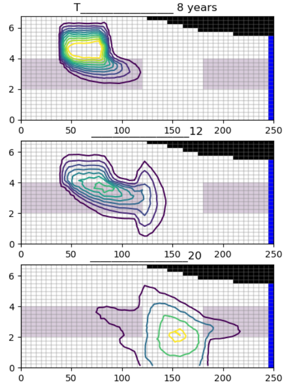

In [9]:
img = Image.open('E:\\15_REPOS\\00_BETAMI\\bin\\Figure\\end.PNG')
size = 0.5 ; out = img.resize( [int(size * s) for s in img.size] ) ; out